<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

**Описание проекта:** Услуга заказа такси -одна из самых удобных решений современного мира. Однако, она имеет свою специфику. Слишком долгое ожидание такси, когда она срочно нужно, либо слишком большая цена на такси отпугавает потенциальных клиентов, что приводит к убыткам как самой транспортной компании, так и его сотрудников. В тоже время простой машин тоже ведет к убыткам компании. Именно поэтому расчет необходимого количества машин очень важен на практике. С помошью данных о количетсве заказах такси мы строим модели машинного обучения, позволяющие оценить и пресказать необходимый уровень количетсва машин в конкретное время.  <br>

**Цель исследования:** создать модели машинного обучения,позволяющей определить количетсво необходимых для подачи клиентам машин такси.<br>

**Ход исследования:**
Для выполнения цели исследования необходимо будет выполнить следующие задачи:
- <u>Первоначальный анализ и предобраотка данных.</u> Загрузка данных, первоначальное их изучение и анализ, их предобработка
- <u>Подготовка данных.</u> кодировка, нормализация и иная подготовка данных для создание модели
- <u>Обучние моделей.</u> Создание модели машинного оучения, подбор гипперпараметров, анализ моделей  
- <u>Вывод </u> Описание результатов исследования, выводы.

Данное исследование может стать основой для исследования и планирование работы транспортной компании.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

import lightgbm as lgb
from statsmodels.tsa.seasonal import seasonal_decompose
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.stattools import adfuller
from sklearn.dummy import DummyRegressor
plt.rcParams["figure.figsize"] = (10,6)

## Подготовка

Загрузка и первоначальный анализ данных

In [ ]:
if os.path.exists('/datasets/taxi.csv'):
    df = pd.read_csv('/datasets/taxi.csv',sep=',',index_col=[0], parse_dates=[0])
else:
    print('Erorr')

In [ ]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [ ]:
df=df.sort_index()
df.index.is_monotonic # проверка отсутствия пропусков

True

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [ ]:
df = df.resample('1H').sum()

<u>Вывод по первой части</u>
На данном этапе выполнения проекта был сделана закрузка и превоначальный анализ данных. В датафрейме содержатся данные о вызове такси за период с 1 марта 2018 года по 31 авгуса 2018 года, без пропусков. Данные были ресемплированы по одному часу.

## Анализ

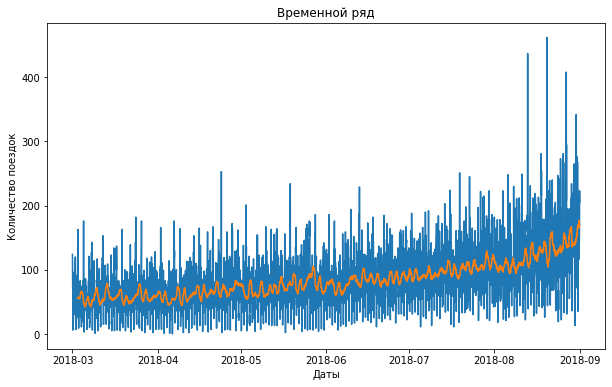

In [ ]:
df['rolling_mean'] = df['num_orders'].shift(24).rolling(24).mean()


plt.plot(df)
plt.title('Временной ряд')
plt.ylabel('Количество поездок')
plt.xlabel('Даты')
plt.show()

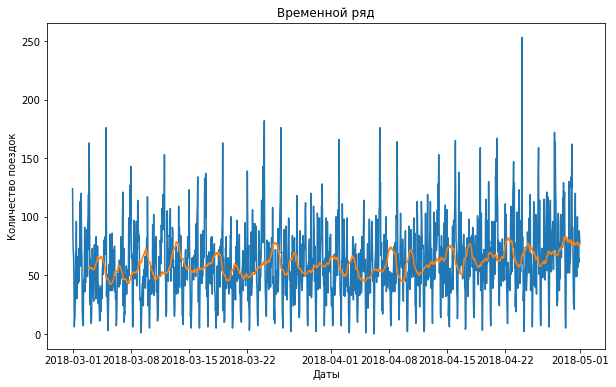

In [ ]:
plt.plot(df['2018-03':'2018-04'])
plt.title('Временной ряд')
plt.ylabel('Количество поездок')
plt.xlabel('Даты')
plt.show()

Ряд нестационарен. Идет увеличение сглаживаемого среднего, он неравномерен.

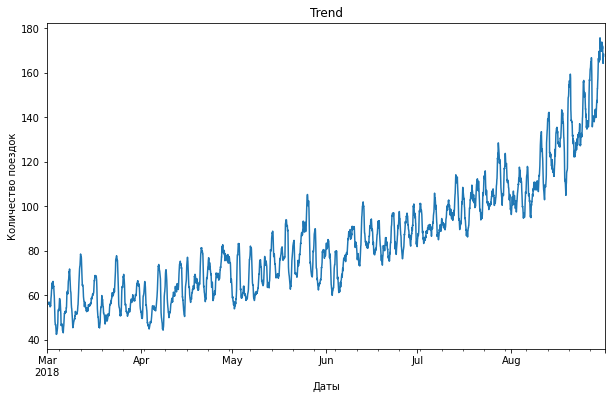

In [ ]:
decomposed =  seasonal_decompose(df['num_orders'])


decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.ylabel('Количество поездок')
plt.xlabel('Даты')
plt.show()

Визуально заметен тренд к увеличению количества заказов такси.

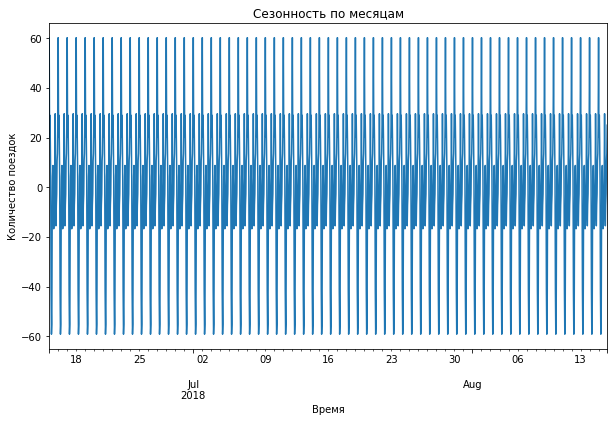

In [ ]:
decomposed.seasonal['2018-06-15':'2018-08-15'].plot()

plt.title('Сезонность по месяцам')
plt.ylabel('Количество поездок')
plt.xlabel('Время')
plt.show()

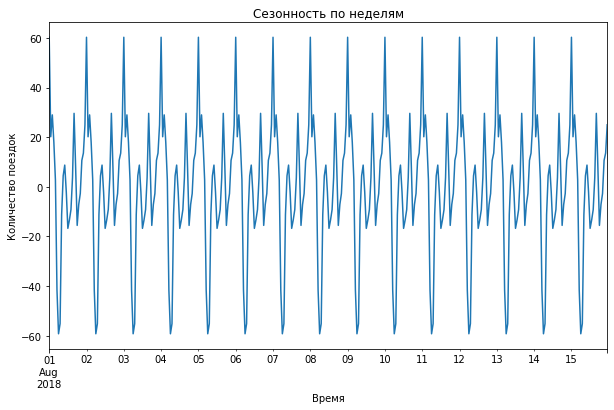

In [ ]:
decomposed.seasonal['2018-08-01':'2018-08-15'].plot()
plt.title('Сезонность по неделям')
plt.ylabel('Количество поездок')
plt.xlabel('Время')
plt.show()

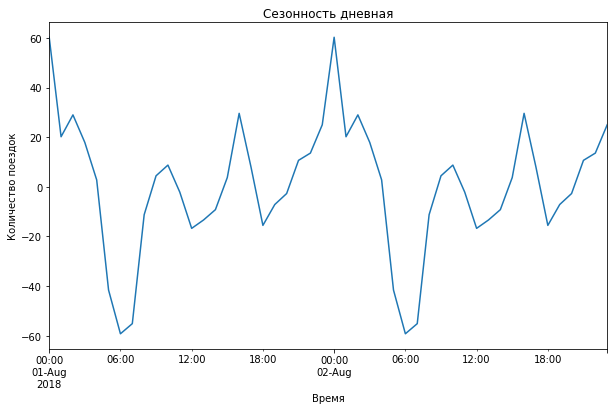

In [ ]:
decomposed.seasonal['2018-08-01':'2018-08-02'].plot()
plt.title('Сезонность дневная')
plt.ylabel('Количество поездок')
plt.xlabel('Время')
plt.show()

Не была выявлена месячная и недельная сезонность. Обнаружена суточная сезонность, количество заказов такси зависит от времени суток.   Пик заказа такси проходится на 12 ночи. Это скорее всего связано с тем, что примерно с этого времени перестает ходить общественный транспорт и пассажиры и поздние работники аэропорта едут домой. Пик активности заказов приходится примерно на 16:00, это скорее всего окончание работы части работников, либо какие-то очень популярные  и многолюдные рейсы. Пик в 7-8 часов, это начало работы аэропорта, те, кто хочет успеть из самолета в город бысрее, чтобы успеть сделать дела в тот же день. Наблюдается спад заказов такси около 6 утра. Пассажиры и работники аэропорта уже дожидаются общественного транспорта или спят. Природа скзанности обусловоена спецификой раьоты аэропорта. Это круглосуточный объект, с большим количеством приезжающих и уезжающих людей круглосуточно.
- Временной ряд нестационарен.

Нулевая гипотеза: тест нестационарен. Альтернативная гипотеза: ряд стационарен.


In [ ]:
alfa =0.01
a =adfuller(df['num_orders'])[1] #тест Дики-Фуллера
print(a)

if a<alfa:

    print('Нулевая гипотеза отвергается. Ряд скорее всего стационарен')
else:
    print('Нулевая гипотеза не отвергается. Ряд скорее всего нестационарен')

0.028940051402612906
Нулевая гипотеза не отвергается. Ряд скорее всего нестационарен


In [ ]:
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek
df['hour'] = df.index.hour

for lag in range(1, 7):
    df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

In [ ]:
df=df.dropna()

In [ ]:
df.head()

,num_orders,rolling_mean,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
datetime,,,,,,,,,,,
2018-03-02 23:00:00,72,56.833333,2,4,23,119.0,101.0,93.0,49.0,89.0,83.0
2018-03-03 00:00:00,163,55.416667,3,5,0,72.0,119.0,101.0,93.0,49.0,89.0
2018-03-03 01:00:00,108,56.875000,3,5,1,163.0,72.0,119.0,101.0,93.0,49.0
2018-03-03 02:00:00,25,57.041667,3,5,2,108.0,163.0,72.0,119.0,101.0,93.0
2018-03-03 03:00:00,64,56.958333,3,5,3,25.0,108.0,163.0,72.0,119.0,101.0


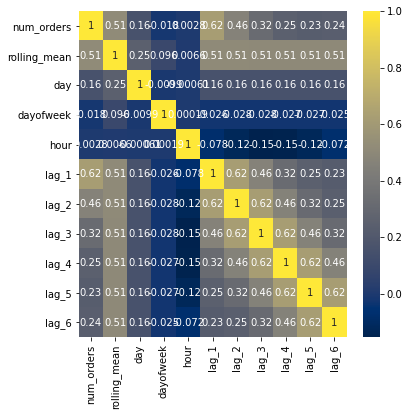

In [ ]:
plt.figure(figsize=(6,6))
sns.heatmap(df.corr(), annot=True, cmap='cividis')
plt.show()

<u>Вывод по второму шагу</u>
На данном этапе было посмотрено распределение признака. Выявлен тренд к увеличению числа такси. Сезонности, зависомости от дня недели или времени года не выявлено.
Выявлена корреляция с данными за предыдущий час и месяцем заказа.

## Обучение

In [ ]:
RANDOM_STATE = 42
TEST_SIZE = 0.1

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
        df.drop(['num_orders'], axis=1),
        df['num_orders'],
        shuffle= False,
        test_size = TEST_SIZE,
        random_state = RANDOM_STATE)

In [ ]:
X_train.columns

Index(['rolling_mean', 'day', 'dayofweek', 'hour', 'lag_1', 'lag_2', 'lag_3',
       'lag_4', 'lag_5', 'lag_6'],
      dtype='object')

In [ ]:
num_columns = [ 'hour', 'day', 'dayofweek', 'lag_1', 'lag_2', 'lag_3','lag_4',
       'lag_5', 'lag_6',
       'rolling_mean']

In [ ]:
data_preprocessor = ColumnTransformer(
    [('num', MinMaxScaler(), num_columns)],
    remainder='passthrough'
)

In [ ]:
pipe_tree = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models',  LinearRegression())
])

In [ ]:
param_grid = [

    {
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(9, 10),
        'models__max_leaf_nodes': range(10, 12),
        #'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },


    {
        'models':  [LinearRegression()],
        'models__normalize':[True, False],
        #'models__alpha':[0.9,1,2,3,5],
        #'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']

    },

        {
        'models': [LGBMRegressor(random_state=RANDOM_STATE)],
        'models__num_leaves': range(8, 10),
        'models__max_depth': range(7, 9)
    }
]

In [ ]:
n = TimeSeriesSplit(n_splits=3)

In [ ]:
search = GridSearchCV(
    pipe_tree,
    param_grid,
    cv=n,
    scoring= 'neg_root_mean_squared_error',
    error_score='raise'
)

In [ ]:
search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', search.best_params_)
print ('Метрика лучшей модели на кросс-валидации :', abs(search.best_score_))

Лучшая модель и её параметры:

 {'models': LGBMRegressor(max_depth=8, num_leaves=9, random_state=42), 'models__max_depth': 8, 'models__num_leaves': 9}
Метрика лучшей модели на кросс-валидации : 28.10594756517899


In [ ]:
result = pd.DataFrame(search.cv_results_)
result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_models__max_depth,param_models__max_leaf_nodes,param_models__normalize,param_models__num_leaves,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.434698,0.126853,0.013882,0.000490,RandomForestRegressor(random_state=42),9,10,NaN,NaN,{'models': RandomForestRegressor(random_state=...,-28.669274,-29.321831,-39.565542,-32.518882,4.989858,6
1,0.434291,0.127692,0.013592,0.000321,RandomForestRegressor(random_state=42),9,11,NaN,NaN,{'models': RandomForestRegressor(random_state=...,-28.510983,-29.089538,-39.124957,-32.241826,4.872836,5
2,0.096716,0.071625,0.028689,0.023507,LinearRegression(),NaN,NaN,True,NaN,"{'models': LinearRegression(), 'models__normal...",-30.697963,-31.501025,-38.458780,-33.552589,3.484657,8
3,0.158430,0.040661,0.038048,0.042529,LinearRegression(),NaN,NaN,False,NaN,"{'models': LinearRegression(), 'models__normal...",-30.697963,-31.501025,-38.458780,-33.552589,3.484657,7
4,0.424285,0.117360,0.007142,0.002643,"LGBMRegressor(max_depth=8, num_leaves=9, rando...",7,NaN,NaN,8,"{'models': LGBMRegressor(max_depth=8, num_leav...",-28.088811,-24.992341,-31.954050,-28.345067,2.847876,3
5,0.333796,0.050824,0.033657,0.040267,"LGBMRegressor(max_depth=8, num_leaves=9, rando...",7,NaN,NaN,9,"{'models': LGBMRegressor(max_depth=8, num_leav...",-27.999089,-24.900210,-32.001478,-28.300259,2.906892,2
6,0.360888,0.093428,0.039414,0.041097,"LGBMRegressor(max_depth=8, num_leaves=9, rando...",8,NaN,NaN,8,"{'models': LGBMRegressor(max_depth=8, num_leav...",-28.088811,-24.992341,-31.954050,-28.345067,2.847876,3
7,0.362151,0.094780,0.038057,0.042195,"LGBMRegressor(max_depth=8, num_leaves=9, rando...",8,NaN,NaN,9,"{'models': LGBMRegressor(max_depth=8, num_leav...",-27.700721,-24.865148,-31.751974,-28.105948,2.826099,1


<u>Вывод по данному шагу</u>
На данном шаге было обучено нескольео моделей. Лучшей моделью стала модель LGBMRegressor. Значение RMSE 28.1

## Тестирование

In [ ]:
y_pred = search.predict(X_test)

In [ ]:
print( 'RMSE на тестовой выборке:', mean_squared_error( squared=False,y_true =y_test, y_pred=y_pred))

RMSE на тестовой выборке: 46.58474328965154


In [ ]:
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train,y_train)
demmy_pred=dummy.predict(X_test)
print( 'RMSE на тестовой выборке-демми:', mean_squared_error( squared=False,y_true =y_test, y_pred=demmy_pred))

RMSE на тестовой выборке-демми: 84.74025917460843


Проверка показала, что созданная модель работает лучше демми-модели со средними значениями.

In [ ]:
y_pred=pd.Series(y_pred)

In [ ]:
data=pd.DataFrame(y_test).reset_index()

In [ ]:
data2 = pd.DataFrame(y_pred)

In [ ]:
result = data.join(data2)
result['datetime']= pd.to_datetime(result['datetime'])
result=result.set_index('datetime')

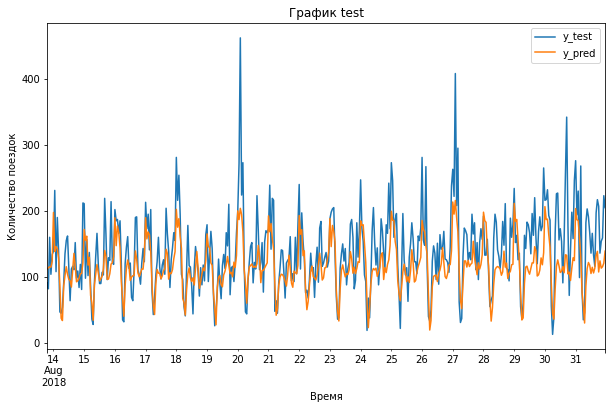

In [ ]:
result.plot()
plt.title('График test')
plt.ylabel('Количество поездок')
plt.xlabel('Время')
plt.legend(['y_test','y_pred'])
plt.show()

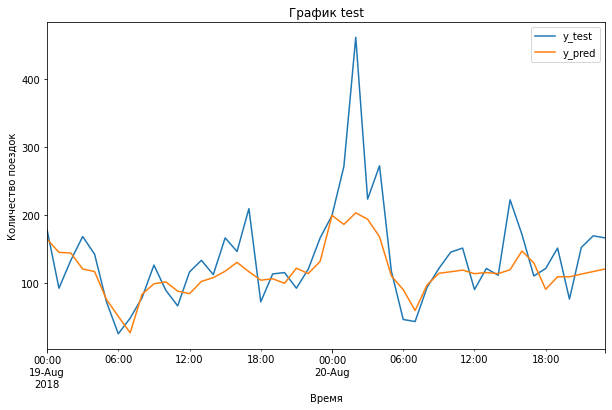

In [ ]:
result['2018-08-19':'2018-08-20'].plot()
plt.title('График test')
plt.ylabel('Количество поездок')
plt.xlabel('Время')
plt.legend(['y_test','y_pred'])
plt.show()

Модель хорошо определяет саму тенденцию роста или снижения количества заказов, среднее, но плохо определяет пики, сильно их сглаживает, часто показывая как будто среднее. Модель не учла общий рост заказов в конце месяца.

## Вывод
В данном проекте была создана модель для предсказания количеcтва нужного такси. Данная модель работает, метрика RMSE у нее равно 46,5